In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from snewpy import snowglobes

from sspike.env import snowglobes_dir

SNOwGLoBES_path = snowglobes_dir # where SNOwGLoBES is located
SNEWPY_models_base = "/Users/joe/src/snewpy/models/"  # directory containing SNEWPY models

In [2]:
distance = 5.0

# set SNOwGLoBES detector to use
detector = "kamland"

# set SNEWPY model type and filename
modeltype = 'Nakazato_2013'
model = '20-200'

# set desired flavor transformation
transformation = 'AdiabaticMSW_NMO'

# Construct file system path of model file and name of output file
# The output file will be stored in the same directory as the model file.
# modelfile = SNEWPY_models_base + "/" + modeltype + "/" + model + '.dat'
modelfile = "/Users/joe/src/snewpy/models/Nakazato_2013/nakazato-shen-z0.02-t_rev200ms-s20.0.fits"
# modelfile should be replaced by sb.sim_path
outfile = modeltype+"_"+model+"_"+transformation
# outfile should be replaced by sb.sn_name

# There are three ways to select a time range.
# Option 1 - don't specify tstart and tend, then the whole model is integrated
#tstart = None
#tend = None

# Option 2 - specify single tstart and tend, this makes 1 fluence file integrated over the window
#tstart = 0.7 * u.s
#tend = 0.8 * u.s

# Option 3 = specify sequence of time intervals, one fluence file is made for each interval
window_tstart = -0.05
window_tend = 20
window_bins = 200
tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) * u.s
tend = tstart + (window_tend - window_tstart) / window_bins * u.s
tmid = (tstart + tend) * 0.5

In [3]:
print("Preparing fluences ...")
tarredfile = snowglobes.generate_fluence(modelfile, modeltype, transformation, distance, outfile, tstart, tend)

Preparing fluences ...


/Users/joe/opt/anaconda3/envs/KLSN/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


In [4]:
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredfile, detector_input=detector)

Running SNOwGLoBES ...


{'kamland': {'Nakazato_2013_20-200_AdiabaticMSW_NMO_28': is_weighted    unweighted      weighted    unweighted      weighted  \
  is_smeared      unsmeared     unsmeared       smeared       smeared   
  channel               ibd           ibd           ibd           ibd   
  E                                                                     
  0.000749     0.000000e+00  0.000000e+00  6.919580e-04  6.919580e-04   
  0.001246     0.000000e+00  0.000000e+00  1.585780e-03  1.585780e-03   
  0.001744     0.000000e+00  0.000000e+00  2.926250e-03  2.926250e-03   
  0.002241     2.291170e-04  2.291170e-04  4.801310e-03  4.801310e-03   
  0.002739     7.675750e-04  7.675750e-04  7.141150e-03  7.141150e-03   
  ...                   ...           ...           ...           ...   
  0.097760     3.570890e-08  3.570890e-08  2.034260e-08  2.034260e-08   
  0.098260     3.213160e-08  3.213160e-08  1.353500e-08  1.353500e-08   
  0.098760     2.890780e-08  2.890780e-08  6.461930e-09  6.461930e-09

In [5]:
print("Collating results ...")
tables = snowglobes.collate(SNOwGLoBES_path, tarredfile, skip_plots=True)

Collating results ...


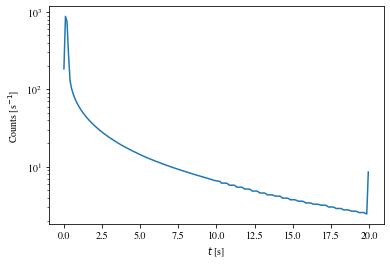

Total Events: 464.89619762491037


In [18]:
%matplotlib inline
nevents = np.zeros(len(tmid))
for i in range(len(tmid)):
    key = f"Collated_{outfile}_{i}_{detector}_events_smeared_weighted.dat"
    for j in range(1,len(tables[key]['header'].split())):
        nevents[i] += sum(tables[key]['data'][j])

# nevents is per bin, convert to per ms
factor = window_bins / (window_tend - window_tstart) / 1

plt.plot(tmid * u.s, nevents * factor)
plt.xlabel("$t$ [s]")
plt.ylabel("Counts [s$^{-1}$]")
plt.yscale('log')
plt.show()
print("Total Events:", sum(nevents))

In [7]:
%matplotlib inline
n_chan = {}
nevents = np.zeros(len(tmid))
for i in range(len(tmid)):
    key = f"Collated_{outfile}_{i}_{detector}_events_smeared_weighted.dat"
    for j in range(1,len(tables[key]['header'].split())):
        if i == 0:
            n_chan[tables[key]['header'].split()[j]] = np.zeros(len(tmid))
        n_chan[tables[key]['header'].split()[j]][i] += sum(tables[key]['data'][j])

# nevents is per bin per s
factor = window_bins / (window_tend - window_tstart)


Text(0.5, 1.0, '200 time bins')

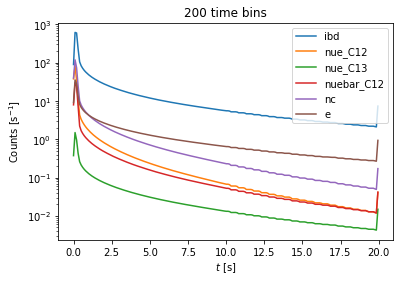

In [8]:

for chan in n_chan.keys():
    plt.plot(tmid * u.s, n_chan[chan] * factor, label=chan)
plt.xlabel("$t$ [s]")
plt.ylabel("Counts [s$^{-1}$]")
plt.legend()
plt.yscale('log')
plt.title(f'{window_bins} time bins')

In [20]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times']
rcParams['font.size'] = 22

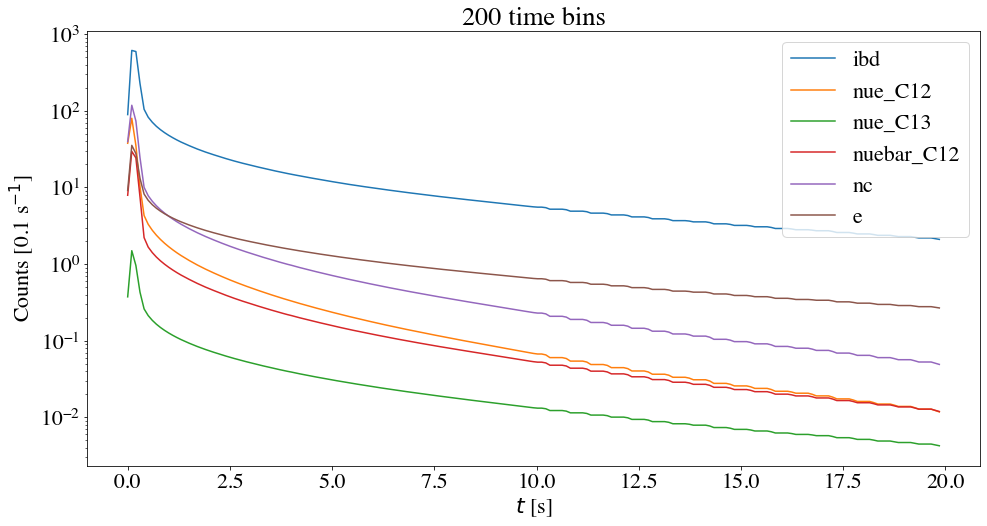

In [22]:
fig, ax = plt.subplots(1, figsize=(16, 8), facecolor='white')
for chan in n_chan.keys():
    ax.plot(tmid[:-1] * u.s, n_chan[chan][:-1] * factor, label=chan)
ax.set_xlabel("$t$ [s]")
ax.set_ylabel("Counts [0.1 s$^{-1}$]")
ax.legend()
ax.set_yscale('log')
plt.title(f'{window_bins} time bins')
plt.show()